<div class="alert alert-block alert-info">
<b>Note:</b> If running a big enough sample, you'll need to start jupyter with the following:
<br><br>
    $ jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10
</div>

# Introduction

The following notebook is a compilation of results extracted from the deep guide demo. The source code can be found 
<a href="https://github.com/Zerfalex/Deep-Guide-Web">here</a> 
and the demo itself can be played 
<a href="https://zerfalex.github.io/Deep-Guide-Web/">here</a>
.

It is a small game made to collect data on the both the API's performance and usability on the project itself.

## Table of Contents:
* [Web App](#Web-App)
* [Notebook Coding](#Notebook-Coding)
* [Main](#Main)
    * [Filtering](#Filtering)
    * [General](#General)
    * [Speed](#Speed)
    * [Accuracy](#Accuracy)
* [Conclusion](#Conclusion)



# Web App

## How the Game Works

<div>
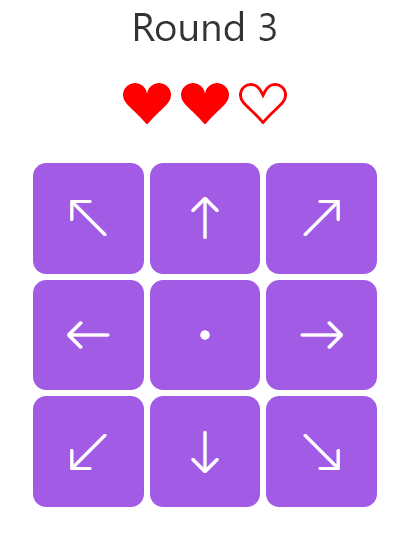
</div>

The above image shows the third round from the game. There are nine buttons, each with a sound associated with it e.g., the top left button plays a sound in front and to the left, and so on.

We also added lives or hearts to make it more appealing to players in order to get more results. Every time the player presses the wrong button a heart is emptied. The player loses after three wrong choices and wins at getting to the 30th round.

## Data Storage

Every new player is assigned a random 5 letter hash for identification.

The data is collected in JSON format, with the following categories

* Sorted: player > Game Number > Game Round > Round Data
* Unsorted: randomHash > Round Data
* Metrics, how many times someone got to round n
* Progression: each player's score each game
* Stats: Players and Wins



Each round data has the following attributes:

~~~
{
    "name": Player hash
    
    "packName": Soundpack name
    "distance": Sound distance from center
    "radius": Sound radius around head
    "axis": (UP-DOWN/FRONT-BACK)
    "soundName": sound file name
    "hrtf": hrtf file name

    "deviceType": (HEADPHONES/EARBUDS/OTHER)
    "deviceName": optional device name

    "trueRound": Round Number, losses included
    "gameRound": Round Number, without losses
    "gameNumber": Game Number

    "buttonPressed": Which button the player pressed
    "soundPlaying": Correct button, where the sound is playing

    "correctX": If player was correct horizontally
    "correctY": If player was correct vertically
    "correct": If player was right

    "totalRounds": Round number across all games
    "totalCorrectX": Number of correctXs across all games
    "totalCorrectY": Number of correctYs across all games
    "totalCorrects": Number of corrects across all games

    "elapsed": Time to press button, seconds
}
~~~

## Sounds Used

For this demo we used a generic ringtone sound with a sizeable distance from the player, close to the API limit since we found that when sounds are very close to not only the player but each other they become harder to tell apart.

Although we would have liked to collect data on multiple sound configurations, there was a worry that it could mean not getting sizeable data on any of them, therefore we went with the one that worked best for us during testing.

## Samples

We collected data on two instances. The first was sent out to friends and family and had a relatively small sample size of 22 players. The second one was posted in various subpages on the website 
<a href="https://www.reddit.com/">reddit</a>
, garnering over 500 players.
The notebook can be run with either one by changing the sampleName bellow.

In [1]:
sampleName = 'sample7'

# Notebook Coding

## Imports

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

import decimal
import functools
import statistics
import time
import math

## Aux Functions <a class="anchor" id="aux-functions"></a>

In [3]:
def getJson(filePath):
    filePath = str(filePath) + ".json"
    with open(filePath) as file:
        jsonObj = json.load(file)
    return jsonObj

def isListOfLists(values):
    return any(isinstance(value, list) for value in values)

#[[1,2,3],[2,4,3]] -> [1.5,3,3]
def concatListMean(values):
    return np.mean(values, axis=0)

#[1,2,3,4,5,7] 2 -> [1.5, 2.5, 3.5, 4.5, 6]
def slidingWindow(values, windowSize):
    window = []
    if isListOfLists(values):
        for value in values:
            window.append(slidingWindow(value, windowSize))
    else:
        for i in range(len(values)-windowSize):
            windowAverage = np.mean(values[i:i+windowSize])
            window.append(windowAverage)
    return window

def plotList(values, title):
    fig = plt.figure()
    fig.text(0.5, 1, title, ha='center')
    if isListOfLists(values):
        for value in values:
            plt.plot(range(len(value)), value)
    else:
        plt.plot(range(1,len(values)+1),values)

def plotList2(values, title, labels=None, start=1):
    fig = plt.figure()
    fig.text(0.5, 1, title, ha='center')
    
    if labels is None:
        if isListOfLists(values):
            for value in values:
                plt.plot(range(start,len(value) + start), value)
        else:
            plt.plot(range(start,len(values) + start),values)
    else:
        #labels = list(map(lambda x: str(x), labels))
        if isListOfLists(values):
            for value in values:
                plt.plot(labels[:len(value)], value)
        else:
            plt.plot(labels,values)
    
def plotListAx(ax, values, title, color='tab:blue', start=1):
    labels = range(start, len(values))
    ax.plot(labels, values[start:], color)
    ax.set_title(title)

def printl(lst, vals=20, chars=100, sep='\n', end='\n'):
    print(*list(map(lambda x: str(x)[:chars-3], lst[:vals])), sep=sep, end=end)
    
def printb(blst):
    for i,b in enumerate(blst):
        print(b, end='\t', sep='>')
        if ((i+1)%3 == 0): print('')
             

In [4]:
t_start = None
t_prev = None
t_cur = None
def startTime():
    global t_start, t_prev
    
    t_start = time.time()
    t_prev = t_start
    
def elapsedTime():
    global t_cur,t_prev
    
    t_cur = time.time()
    r = t_cur - t_prev
    t_prev = t_cur
    return r
    
def totalElapsedTime():
    return time.time() - t_start

## Stats Functions  <a class="anchor" id="stats-functions"></a>

In [23]:
#Gets all scores for each player or gets X scores for players with at least X games
def getScores(jsonStats, minGames = -1):
    scores = []
    progStats = jsonStats["progression"][soundPack]
    for player in progStats:
        playerScores = list(progStats[player].values())
        playerGames = len(playerScores)
        if minGames<0:
            scores.append(playerScores)
        elif playerGames>=minGames:
            scores.append(playerScores[:minGames])
    return scores

def getUnsortedRounds(jsonStats):
    r = list(jsonStats['unsorted'].values())
    return r

def getSortedByButton(jsonStats):
    r = [[] for i in range(9)]
    for v in getUnsortedRounds(jsonStats):
        r[v['soundPlaying']].append(v)
    return r

def getSortedByButton2(attribute):
    r = [[] for i in range(9)]
    for v in uRounds:
        r[v[attribute]].append(v)
    return r


def getDetails(uRounds):
    users = []
    r = {
        'maxRounds': 0,
        'maxGames': 0,
        'headphones': 0,
        'earbuds': 0,
    }
    for v in uRounds:
        r['maxRounds'] = max(r['maxRounds'], v['totalRounds'])
        r['maxGames'] = max(r['maxGames'], v['gameNumber'])
        #unique
        if v['name'] not in users:
            r[v['deviceType']] += 1
            users.append(v['name'])
        
        r['players'] = len(users)
        
    return r

def percentilePosition(lst, p):
    #Janks at 1
    copy = list(lst)
    
    copy.sort()

    target = p

    l = len(copy)

    pos = math.floor((l - 1) * target)

    val = copy[pos]

    first, last = -1, 0
    for i,s in enumerate(copy):
        if s == val:
            if first < 0:
                first = i
            last = max(last, i)

    extraBit = (pos-first)/(last-first)

    coolVal = val + extraBit
    
    return coolVal

## Math Functions <a class="anchor" id="math-functions"></a>

In [6]:
def portion(a, *b, inc=True):
    try:
        return a /(a + sum(b))
    except ZeroDivisionError as e:
        return 0


def percent(val, dec=1):
    return str(round(val * 100, dec)) + '%'
  
#returns rounded mean
def meanr(lst, dec = 1):
    return round(statistics.mean(lst), dec)

#returns rounded median
def medianr(lst, dec = 1):
    return round(statistics.median(lst), dec)

#returns rounded median
def moder(lst, dec = 1):
    return round(statistics.mode(lst), dec)

def doubleR(lst, dec = 1):
    if isListOfLists(lst):
        mean, median = [],[]
        for v in lst:
            r = doubleR(v, dec=dec)
            mean.append(r[0])
            median.append(r[1])
        return (mean, median)
    else:
        return (round(statistics.mean(lst), dec),
                round(statistics.median(lst), dec))

def tripleR(lst, dec = 1):
    if isListOfLists(lst):
        mean, median, mode = [],[],[]
        for v in lst:
            r = tripleR(v, dec=dec)
            mean.append(r[0])
            median.append(r[1])
            mode.append(r[2])
        return (mean, median, mode)
    else:
        return (round(statistics.mean(lst), dec),
                round(statistics.median(lst), dec),
                round(statistics.mode(lst), dec))


# Main

In [7]:
jsonStats = getJson(sampleName)
soundPack = '2_8_DU_phone3shorter_irc_1037'

gameCap = 40
scores = list(filter(lambda x: len(x) < gameCap,getScores(jsonStats)))

## Filtering

In this first section we filter out any undesirable rounds.

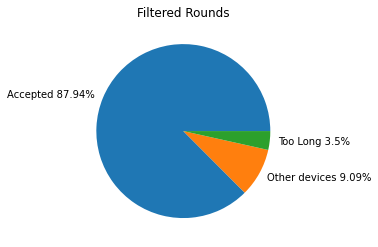

In [8]:
og = getUnsortedRounds(jsonStats)

other = list(filter(lambda x: x['deviceType'] == 'other', og))
uRounds = otherDevices = list(filter(lambda x: x['deviceType'] != 'other', og))

tooLong = 8
long = list(filter(lambda x: x['elapsed'] >= tooLong, og))
uRounds = list(filter(lambda x: x['elapsed'] < tooLong, uRounds))

plt.pie([len(uRounds), len(other), len(long)],
        labels = [
            f'Accepted {percent(len(uRounds)/ len(og), 2)}',
            f'Other devices {percent(len(other)/ len(og), 2)}',
            f'Too Long {percent(len(long)/ len(og), 2)}'])
plt.title('Filtered Rounds')
plt.show()

We chose to filter out any rounds in which the user listened through speakers, as it is impossible to distinguish location that way.

We also removed any rounds over 8 seconds, due to outliers, as 8 seconds should be enough to decide. More than that, and we assume the user stopped playing for some reason. 

In [9]:
details = getDetails(uRounds)

print(details)

{'maxRounds': 1154, 'maxGames': 155, 'headphones': 355, 'earbuds': 169, 'players': 524}


## General

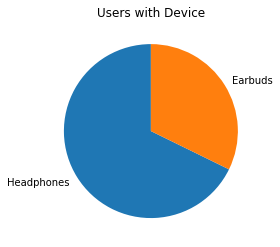

In [10]:
plt.pie([details['headphones'], details['earbuds']], labels = ['Headphones', 'Earbuds'], startangle=90)
plt.title('Users with Device')
plt.show()

How many players used headphones vs earbuds, roughly two thirds are on headphones. 

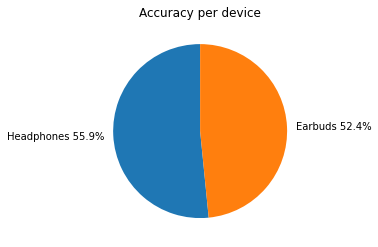

In [11]:
accs = {'headphones': [], 'earbuds': []}

for r in uRounds:
    accs[r['deviceType']].append(r['correct'])
    
h = meanr(accs['headphones'], dec=4)
e = meanr(accs['earbuds'], dec=4)

plt.title('Accuracy per device')
plt.pie([h,e], labels = [f'Headphones {percent(h)}', f'Earbuds {percent(e)}'], startangle=90)

plt.show()

We can see that there's very little difference between headphones and earbuds users in terms of overall accuracy. 

Although there are many types of headphones/earbuds, since the difference is so small, we can assume it is not too relevant.

## Speed

This section pertains to speed, which is the time taken to press the button since the last round. All the following results about speed will be presented in seconds.

Code wise, speed might also be referred to as ‘elapsed’.

### Global Speed

The mean and median of all users' time.

In [12]:
globalSpeedMean = meanr(map(lambda x: x['elapsed'], uRounds), dec=2)
globalSpeedMedian = medianr(map(lambda x: x['elapsed'], uRounds), dec=2)
#nature of game doesnt punish slowness
print('Global Speed Mean: ' + str(globalSpeedMean))
print('Global Speed Median: ' + str(globalSpeedMedian))

Global Speed Mean: 2.06
Global Speed Median: 1.64


Even though we removed some outliers (longer than 10 seconds) we are still left with a sizeable gap between mean and median. This means we still have some slower rounds in the dataset, which is fine since we did not want to remove too many.

### Speed Per Button

These images show the time it takes to press a button if the sound being played is on said square. The blue values are the fastest and the red the slowest.

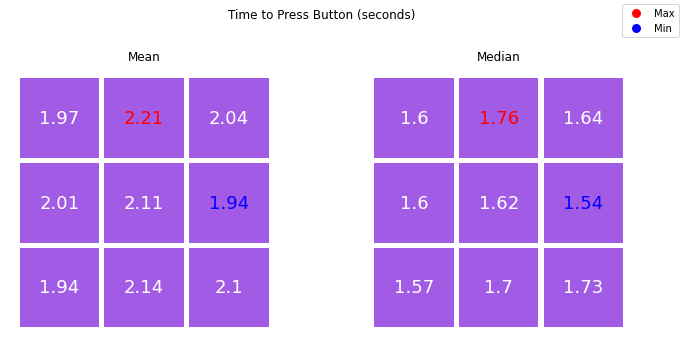

In [13]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def addButton(ax, size, x, y, text='text', color = '#A25BE4', textColor = 'white', radius=2):
    rectangle =  plt.Rectangle((x,y), size, size, fc=color, capstyle='round')
    half = size/2
    ax.text(x+half, y+half, text, 
            horizontalalignment='center',verticalalignment='center', 
            color=textColor, fontsize=18)
    ax.add_patch(rectangle)

def addButtons(ax, size, values, title, margin=1, extra=True, maxColor = 'red', minColor = 'blue'):
    if extra:
        P = values.index(max(values))
        p = values.index(min(values))
    x,y = 0,0
    pos = -1
    for i in range(3)[::-1]:
        y += margin 
        for j in range(3):
            x += margin
            pos = i*3+j
            c = maxColor if pos == P else minColor if pos == p else 'white'
            addButton(ax, size, x, y, text=values[pos], textColor = c)
            x += size
        x = 0
        y += size
    ax.axis('off')
    ax.axis('scaled')
    ax.set_title(title)

    
speedPerButton = list(map(lambda x: list(map(lambda y: y['elapsed'], x)),getSortedByButton2('soundPlaying')))

(buttonSpeedMean,buttonSpeedMedian) = doubleR(speedPerButton, dec = 2)    

fig, axs = plt.subplots(1, 2)

addButtons(axs[0], 3, buttonSpeedMean, title='Mean', margin=0.2)
addButtons(axs[1], 3, buttonSpeedMedian, title='Median',  margin=0.2)

fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout(rect=[0, 0.03, 1, 0.87])
fig.suptitle('Time to Press Button (seconds)')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Max',markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Min',markerfacecolor='b', markersize=10),
                ]

fig.legend(handles=legend_elements, fontsize=10)

plt.show()

The faster values are on the sides and slower ones in the middle. This is due to left-right being easier to tell apart than up-down. The middle seems to be the hardest one to locate, likely since it has no special tells.

### Speed progression over Games/Rounds

The mean and median speed of every game and round. This shows how speed progresses after a certain number of games/rounds.

In [14]:
def getAnyProgression(roundLimit, gameLimit, attribute):

    #makes ranges based on limit(unless there's fewer than)
    roundRange = range(min(roundLimit, details['maxRounds']) + 1)
    gameRange = range(min(gameLimit, details['maxGames']) + 1)

    rounds = list(roundRange)
    games = list(gameRange)

    #empty list of lists to hold values for every speed per game/round
    perRound = [[] for _ in roundRange]
    perGame = [[] for _ in gameRange]

    #fills lists checking for the limit correspondingly
    for v in uRounds:
        rnd = v['totalRounds']
        game = v['gameNumber']
        elapsed = v[attribute]

        if rnd <= roundLimit:
            perRound[rnd].append(elapsed)
        if game <= gameLimit:
            perGame[game].append(elapsed)

    #first element is zero since no round 0
    meanPerRound = [0]
    medianPerRound = [0]
    meanPerGame = [0]
    medianPerGame = [0]

    #fills mean/median lists with values from above
    for attribs in perRound[1:]:
        meanPerRound.append(meanr(attribs,2))
        medianPerRound.append(medianr(attribs,2))

    for attribs in perGame[1:]:
        meanPerGame.append(meanr(attribs,2))
        medianPerGame.append(medianr(attribs,2))

    return meanPerRound,medianPerRound,meanPerGame,medianPerGame

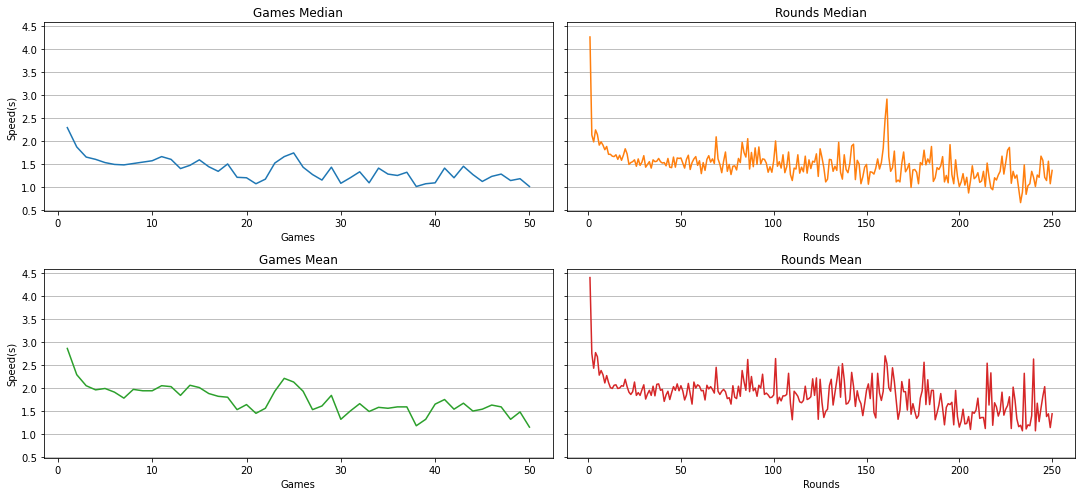

In [15]:
meanSpeedsRound,medianSpeedsRound,meanSpeedsGame,medianSpeedsGame = getAnyProgression(250,50,'elapsed')

fig, axs = plt.subplots(2, 2, sharey=True)

for ax in axs.flat[::2]: ax.set(xlabel='Games', ylabel='Speed(s)')
for ax in axs.flat[1::2]: ax.set(xlabel='Rounds')
for ax in axs.flat: ax.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
    
plotListAx(axs[0, 0], medianSpeedsGame, 'Games Median')
plotListAx(axs[0, 1], medianSpeedsRound, 'Rounds Median', color='tab:orange')
plotListAx(axs[1, 0], meanSpeedsGame, 'Games Mean', color='tab:green')
plotListAx(axs[1, 1], meanSpeedsRound, 'Rounds Mean', color='tab:red')

# Hide x labels and tick labels for top plots and y ticks for right plots.

    
fig.set_figwidth(15)
fig.set_figheight(7)
fig.tight_layout()

On the left column we can see the progression over each game, on the right, each round. Note that the rounds are across multiple games.

By looking at these graphs we can see that, after the first round, there is a significant decrease in time taken, so much so that the first game is already quite fast.

There is an improvement seen across multiple games, whether this is due to the user getting accustomed to 3D sound or just memorizing each sound is hard to tell without asking the users themselves, although we believe it to be a mix of both.

## Accuracy

### Global Accuracy

In [16]:
acc = meanr(list(map(lambda x: x['correct'], uRounds)),2)
print(f'Overall Accuracy was: {acc}')

accX = meanr(list(map(lambda x: x['correctX'], uRounds)),2)
accY = meanr(list(map(lambda x: x['correctY'], uRounds)),2)

print(f'Horizontal Accuracy was: {accX}')
print(f'Vertical Accuracy was: {accY}')

Overall Accuracy was: 0.55
Horizontal Accuracy was: 0.85
Vertical Accuracy was: 0.6


Here we can see that telling from left to right is far easier than up-down, as expected. The fact that vertical accuracy is not that low means that while harder, it is not impossible to differentiate.

### Accuracy per sound location

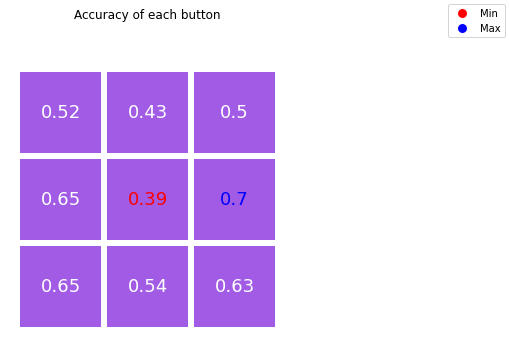

In [17]:
accPerButton = list(map(lambda x: list(map(lambda y: y['correct'], x)),getSortedByButton2('soundPlaying')))

(buttonAccMean,_) = doubleR(accPerButton, dec = 2) 

fig, axs = plt.subplots(1)

addButtons(axs, 3, buttonAccMean, title='', margin=0.2, maxColor = 'blue', minColor = 'red')

fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout(rect=[0, 0.03, 1, 0.87])
fig.suptitle('Accuracy of each button')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Min',markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Max',markerfacecolor='b', markersize=10),
                ]

fig.legend(handles=legend_elements, fontsize=10)

plt.show()

Just like the time per button, the middle seems to perform the worse, due to its indistinctiveness.

The sides in the middle and down seem to be more distinguishable from the top and middle.

### Accuracy progression over Games/Rounds

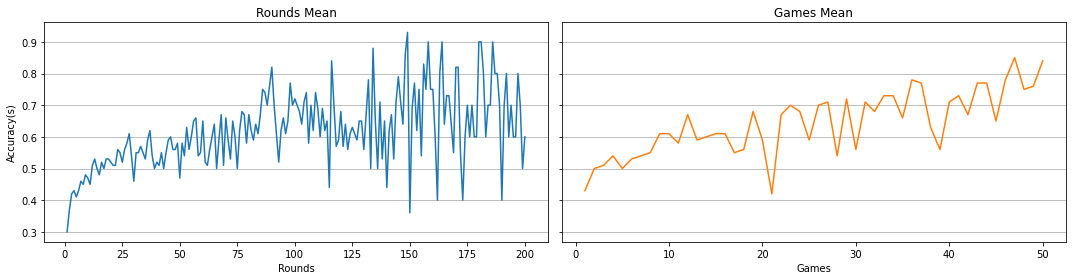

In [18]:
meanSpeedsRound,_,meanSpeedsGame,_ = getAnyProgression(200,50,'correct')

fig, axs = plt.subplots(1, 2, sharey=True)

for ax in axs.flat: ax.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
    
plotListAx(axs[0], meanSpeedsRound, 'Rounds Mean')
axs[0].set(xlabel='Rounds', ylabel='Accuracy(s)')
plotListAx(axs[1], meanSpeedsGame, 'Games Mean', color='tab:orange')
axs[1].set(xlabel='Games')

# Hide x labels and tick labels for top plots and y ticks for right plots.

    
fig.set_figwidth(15)
fig.set_figheight(4)
fig.tight_layout()

Here we can see that there is an improvement to accuracy over enought games/rounds. On the fiftieth we see alomost double the accuracy.

While rounds are a bit more volatile, results-wise, we can still observe an increase.

### Accuracy after n perfect rounds

This is the accuracy of the rest of a game where the player got to a certain round without making a single mistake. 

For example, the mean accuracy of the remaining game in which the player got to round 10 without erring once.

As such the value at round 1 matches the global mean accuracy.

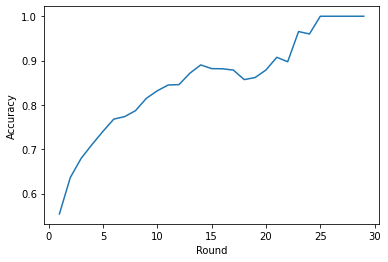

In [19]:
#Accuracy after n perfect rounds
maxRounds = 30

def perfectUntil(rnd):
    users = {}

    for r in uRounds:
        tr = r['trueRound']
        if tr == rnd and tr == r['gameRound']:
            name = r['name']
            game = r['gameNumber']

            if name not in users:
                users[name] = set()
            users[name].add(game)



    f = filter(lambda x: x['name'] in users and x['gameNumber'] in users[x['name']] and x['trueRound'] >= rnd, uRounds)

    return list(f)

tally = []
for i in range(1,maxRounds):
    tally.append(meanr(list(map(lambda x: x['correct'], perfectUntil(i))), dec = 4))

plt.plot(range(1,maxRounds), tally)
#Round reached without failing once
plt.xlabel('Round')
#Accuracy after reaching said round e.g. accuracy after 5 no miss rounds
plt.ylabel('Accuracy')
plt.show()

This graph shows that players who make it to later rounds without any mistakes are more likely to not err.

One possibility is that making a mistake early on ruins the chances of winning, therefore it is better to throw the game(by failing on purpose) to give up and try again.
On the other hand, it might just mean that a good player will keep being good well after getting a perfect score.

The flat 1 accuracy towards the latter rounds is somewhat biased, since not many users make it that far, and those who do, should have no problems finishing.

### Speed-Accuracy Correlation

The accuracy of a press made within a certain timeframe.

Ex: The accuracy of presses within 1 to 1.5 seconds time

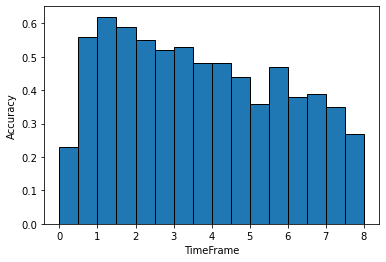

In [20]:
interval = 0.5
lim = 8

lim = min(lim, tooLong)

buckets = math.ceil((lim / interval))

accuracies = [[] for _ in range(buckets)]

for r in uRounds:
    bucket = math.floor(r['elapsed'] / interval)
    if bucket < buckets:
        accuracies[bucket].append(r['correct'])

accuracy = list(map(lambda x: meanr(x, dec=2), accuracies))
times = list(map(lambda x: x * interval, range(buckets)))



plt.bar(times, height = accuracy, width = interval, align='edge', edgecolor='black')
plt.xlabel('TimeFrame')
plt.ylabel('Accuracy')

plt.show()

We can see that people who press faster than half a second have very poor results, these are probably random presses, the first attempts or, even making the wrong choice on purposed to finish the game quickly.

Other than that we can see that the slow the press the worse the accuracy, meaning listening for longer won't make it easier to detect.

### Total Scores Obtained

A histogram of all scores obtained with percentile values.

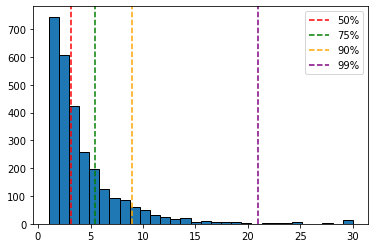

In [24]:
s2 = list(functools.reduce(lambda a,b: a + b, scores))


plt.hist(s2, 30, edgecolor='black')

plt.axvline(x=percentilePosition(s2, 0.5), color='red', linestyle='--', label='50%')
plt.axvline(x=percentilePosition(s2, 0.75), color='green', linestyle='--', label='75%')
plt.axvline(x=percentilePosition(s2, 0.90), color='orange', linestyle='--', label='90%')
plt.axvline(x=percentilePosition(s2, 0.99), color='purple', linestyle='--', label='99%')

plt.legend()

plt.show()

Half of all games only make it to round 2, and only 10% make it past 10. Like with the perfect round accuracy, a good method (for the player) is to discard early mistake games and try again.

It is interesting that there are more wins (30) than scores above 15. Our theory is that past a certain point people are so used to the sounds that there's little chance to get it wrong. Plus, once someone wins, they are not very likely to play again.

### Average Score per Game

The average result of every nth game score.

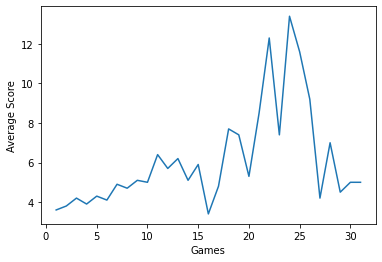

In [22]:
m = 0
for s in scores: m = max(m, len(s))

r = [[] for _ in range(m)]

for s in scores:
    for i,v in enumerate(s):
        r[i].append(v)
        
    
R = list(map(lambda x: meanr(x) if len(x) > 0 else 0, r))

plt.plot(range(1,len(R)), R[1:])

plt.xlabel('Games')
plt.ylabel('Average Score')
plt.show()

The results gradually improve as the user gets accustomed to the sounds. 

Near game 25 we can see a big dip in score, this would be fewer players getting this far, and the good players having already beaten the game and moved on.

# Conclusion

First, it is a good sign that there seems to be little difference in accuracy between listening devices. Our project being an app means it would be used on a phone on multiple environments therefore the user would likely used earbuds, which are typically worse than headphones.

Regarding speed, it appears that with practise it can be improved and even lead to better accuracy. The fact that the user must click a button might also introduce some delay which means the response time can be even faster.

The middle sound seems to behave quite poorly, this is likely due to not feeling different enough, or maybe the user hearing a direction where there is none, since 8/9 have at least one.
Accuracy was in fact quite low, but just like speed it seems to be trainable by the user. Aside from that there were multiple other configurations we wanted to try: different hrtfs, sound distance configurations and even a different sound altogether.

Different hrtfs especially, as these can make it so someone hears very easily while another person will struggle heavily.
In summation, it shows some promises and some flaws, with further testing required to sort them out.
